In [2]:
#Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [3]:
#load multi-session mat files

#multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
multisession_mat_file = os.path.abspath("/home/jupyter/temp/combined_new_old2.mat")
#multisession_mat_file_behavior = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_behavior.mat")
multisession_mat_file_behavior = os.path.abspath("/home/jupyter/temp/combined_behavior.mat")

# print('loading multi-session imaging data...')
# multi_session_data = BCI_analysis.io_matlab.read_multisession_mat_2022(multisession_mat_file)
print('loading multi-session behavior data...')
multi_session_behavior_data = BCI_analysis.io_matlab.read_multisession_behavior_mat(multisession_mat_file_behavior)



loading multi-session behavior data...


In [4]:
# using data from .mat file 
from oasis.functions import deconvolve
importlib.reload(BCI_analysis)
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")

plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'trial_start_original':[]}
needed_subject = 'BCI34'
do_deconvolve = False
convolve_movement_data = False
keep_post_reward = True
if convolve_movement_data:
    
    if keep_post_reward:
        aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved_with_reward/")
    else:
        aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/")
        
    convolve_tau = 0.7
else:
    if keep_post_reward:
        aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/")
    else:
        aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
    convolve_tau = 0
for mat_session_index in range(len(multi_session_behavior_data['session'])):
    # if multi_session_behavior_data['mouse'][mat_session_index] != needed_subject:
    #     continue
    # try:
    try:
        mouse = multi_session_behavior_data['mouse'][mat_session_index][:3]+'_'+multi_session_behavior_data['mouse'][mat_session_index][3:]
    except:
        print('mouse ID missing, skipping')
        continue
    session = multi_session_behavior_data['session'][mat_session_index]
    camera = "side"
    data = {'F':multi_session_behavior_data['df_closedLoop'][mat_session_index].T,
           'trial_start':multi_session_behavior_data['trial_start'][mat_session_index],
           'reward':multi_session_behavior_data['rew'][mat_session_index],
           'cn':int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1,
           'si':multi_session_behavior_data['dt_si'][mat_session_index].tolist()}

    if do_deconvolve:
        spikes_matrix= []
        for F_trace in data['F']:
            c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
            spikes_matrix.append(s)
        data['F'] = np.asarray(spikes_matrix)


    dict_aligned = BCI_analysis.pipeline_align.get_aligned_data(suite2p_path, 
                                                                dlc_base_dir, 
                                                                bpod_path, 
                                                                sessionwise_data_path, 
                                                                aligned_data_path, 
                                                                motion_energy_base_dir,
                                                                raw_video_path,
                                                                mouse=mouse, 
                                                                FOV=None, 
                                                                camera=camera, 
                                                                session=session, 
                                                                sampling='down', 
                                                                functions = ['diff','diff_signed','mean'],
                                                                function_window = 20,  ### important variable for downsampling 1 for facerhythm - 20/200 for DLC
                                                                convolve_tau = convolve_tau,#,0.7, #.7
                                                                plot = False,
                                                                overwrite=False,
                                                                use_provided_data=True,
                                                                add_motion_energy = False,
                                                                source_data = data,
                                                                face_rhythm_base_dir = face_rhythm_base_dir,
                                                                use_face_rhythm = False,
                                                                match_with_face_rhythm = False,
                                                                only_up_to_reward = not keep_post_reward)
    DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])
    F = np.concatenate(dict_aligned['F_aligned'], axis=1)

    multi_session_dict['mouse'].append(multi_session_behavior_data['mouse'][mat_session_index])
    multi_session_dict['session'].append(multi_session_behavior_data['session'][mat_session_index])
    multi_session_dict['cn'].append(int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1)
    multi_session_dict['mat_idx'].append(mat_session_index)
    multi_session_dict['DLC_aligned'].append(DLC_aligned)
    multi_session_dict['F'].append(F)
    multi_session_dict['trial_end_frames'].append(dict_aligned['trial_start_indices'])
    multi_session_dict['F_original'].append(data['F'])
    multi_session_dict['trial_start_original'].append(data['trial_start'])
    #break
        
        
    # except:
    #     print('no luck with session {}'.format(mat_session_index))


    
    
    
print(dict_aligned.keys())



/home/jupyter/Scripts/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_33/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_33/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_33/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_33/063022-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_33/070122-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_34/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_34/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_with_reward/BCI_34/062922-dict_aligned-downsampled.npy
File fou

In [5]:
# bootstrapping of amplitudes 
#
from sklearn.utils import resample
plot_amplitudes = False
max_p = .01
n_bootstrap = 1000
step_back = 40 #baseline before trial start (in frames)
step_forward = 200 #integration time after trial start (frames)
trace_time = np.arange(-step_back,step_forward)/20
# check if CNs are really increasing it's activity - who are the other cells that increase their activity
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['amplitude'] = []
multi_session_dict['previous_amplitude'] = []
multi_session_dict['delta_amplitude'] = []
multi_session_dict['p_increase'] = []
multi_session_dict['p_decrease'] = []
for session_i,session in enumerate(multi_session_dict['session']):
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session
           
            now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
            prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
            real_deltas = np.nanmean(now_amplitudes,1)-np.nanmean(prev_amplitudes,1)
            cn = multi_session_dict['cn'][session_i]

            
            prev_mean_amplitude_bootstrap_list = []
            now_mean_amplitude_bootstrap_list = []

            for bootstrap_i in range(n_bootstrap):
                now_indices = resample(np.arange(now_amplitudes.shape[1]))
                now_mean_amplitude_bootstrap_list.append(np.mean(now_amplitudes[:,now_indices],1))
                prev_indices = resample(np.arange(prev_amplitudes.shape[1]))
                prev_mean_amplitude_bootstrap_list.append(np.mean(prev_amplitudes[:,prev_indices],1))
            now_mean_amplitude_bootstrap_list = np.asarray(now_mean_amplitude_bootstrap_list)
            prev_mean_amplitude_bootstrap_list = np.asarray(prev_mean_amplitude_bootstrap_list)
            delta_amplitudes_bootstrap = now_mean_amplitude_bootstrap_list-prev_mean_amplitude_bootstrap_list
            delta_sd = np.std(delta_amplitudes_bootstrap,0)


            cell_order = np.argsort(real_deltas)
            significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cell_order]<max_p
            significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)[cell_order]<max_p
            
            multi_session_dict['delta_amplitude'].append(real_deltas)
            multi_session_dict['p_increase'].append(1-np.nanmean(delta_amplitudes_bootstrap>0,0))
            multi_session_dict['p_decrease'].append(1-np.nanmean(delta_amplitudes_bootstrap<0,0))
            multi_session_dict['amplitude'].append(np.nanmean(now_amplitudes,1))
            multi_session_dict['previous_amplitude'].append(np.nanmean(prev_amplitudes,1))
            if plot_amplitudes:
                fig = plt.figure(figsize = [15,20])
                ax = fig.add_subplot(2,1,1)

                ax.plot(np.argmax(cell_order==cn),real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.errorbar(np.arange(len(cell_order)),real_deltas[cell_order],yerr = delta_sd[cell_order],fmt='.',color = 'black',alpha = .5)
                ax.plot(np.arange(len(cell_order))[significantly_increasing_indices],real_deltas[cell_order][significantly_increasing_indices],'ro')
                ax.plot(np.arange(len(cell_order))[significantly_decreasing_indices],real_deltas[cell_order][significantly_decreasing_indices],'bo')
                ax.set_xlabel('cell#')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))
                significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)<max_p
                significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)<max_p
                #now_ampls = sklearn.utils.resample(now_amplitudes)

                ax = fig.add_subplot(2,1,2)
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(np.nanmean(prev_amplitudes,1),real_deltas,'.',color = 'black')
                ax.errorbar(np.nanmean(prev_amplitudes,1),real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Amplitude in previous session')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))                
            continue
    multi_session_dict['delta_amplitude'].append([])
    multi_session_dict['p_increase'].append([])
    multi_session_dict['p_decrease'].append([])
    multi_session_dict['amplitude'].append([])
    multi_session_dict['previous_amplitude'].append([])
        
            
            

In [5]:
bigmatrix = np.concatenate([np.concatenate(all_fit_session_matrices,1),np.concatenate(all_test_session_matrices,1)],0)
p = np.corrcoef(bigmatrix)

NameError: name 'all_fit_session_matrices' is not defined

(44590, 108)
trial length is 135 frames, 82 and 78 trials are used from 063022 and 070122
(44983, 108)
trial length is 191 frames, 81 and 70 trials are used from 062922 and 063022
(32565, 108)
trial length is 163 frames, 27 and 89 trials are used from 062822 and 062922
(35186, 108)
trial length is 163 frames, 86 and 27 trials are used from 062722 and 062822
(29498, 108)
trial length is 133 frames, 73 and 47 trials are used from 062922 and 063022
(32813, 108)
trial length is 119 frames, 71 and 75 trials are used from 062822 and 062922
(38911, 108)
trial length is 119 frames, 105 and 71 trials are used from 062722 and 062822
(33333, 108)
trial length is 157 frames, 68 and 46 trials are used from 063022 and 070122
(36834, 108)
trial length is 180 frames, 47 and 64 trials are used from 062922 and 063022
(48265, 108)
trial length is 180 frames, 119 and 47 trials are used from 062822 and 062922
(43255, 108)
trial length is 155 frames, 83 and 80 trials are used from 063022 and 070122
(48209, 

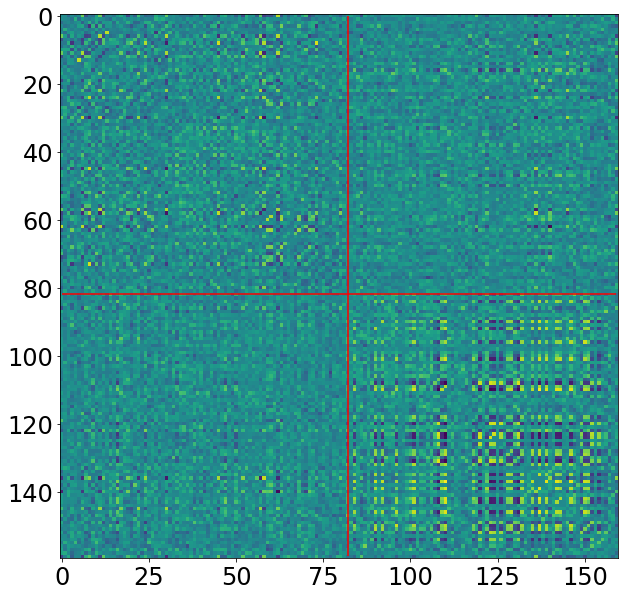

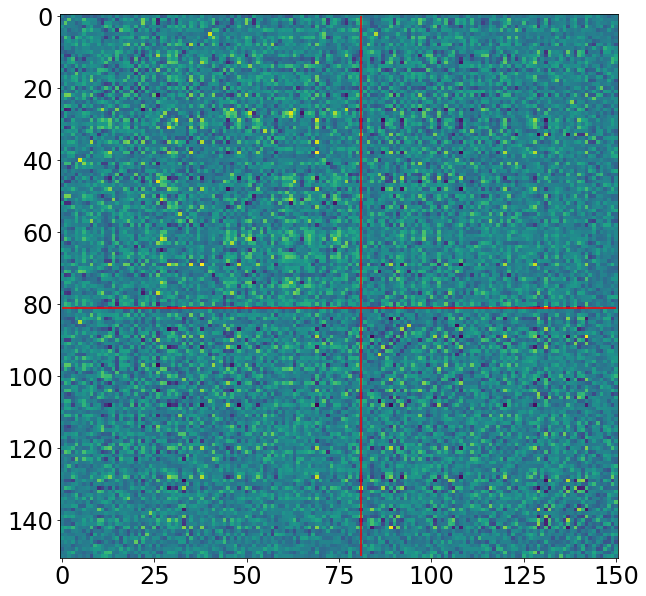

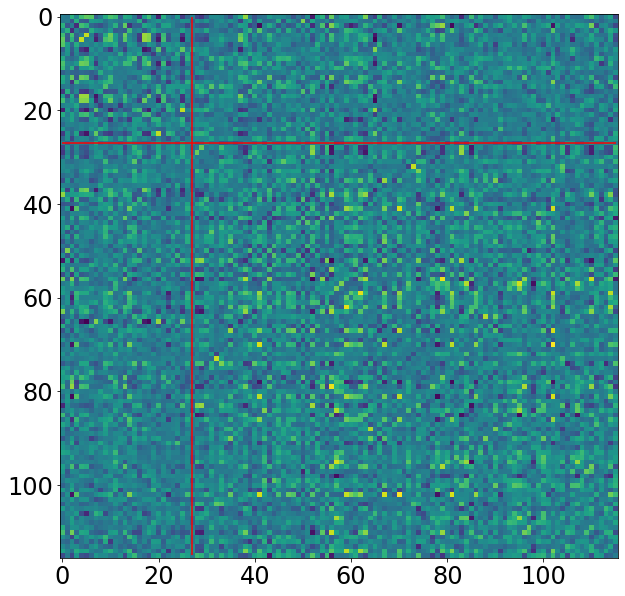

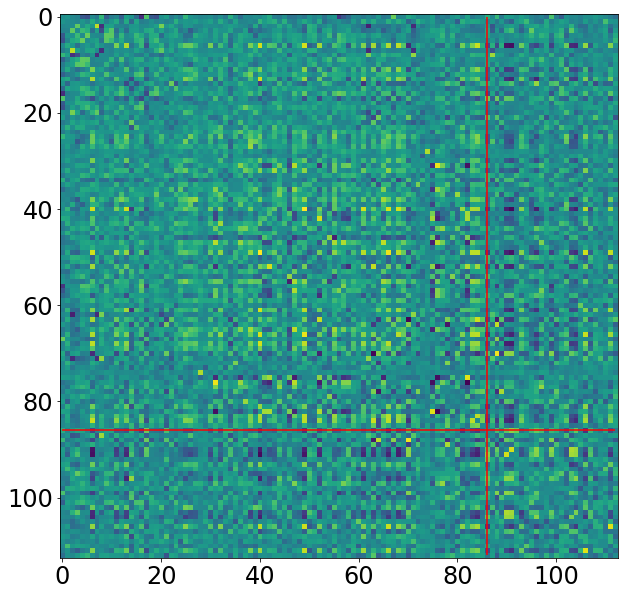

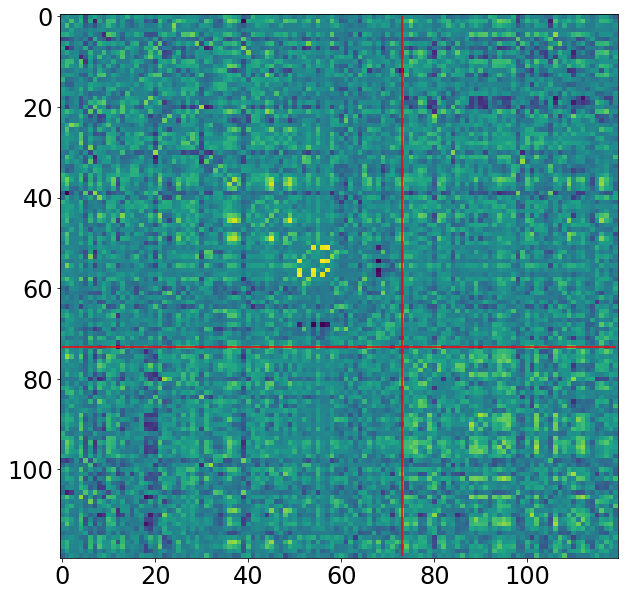

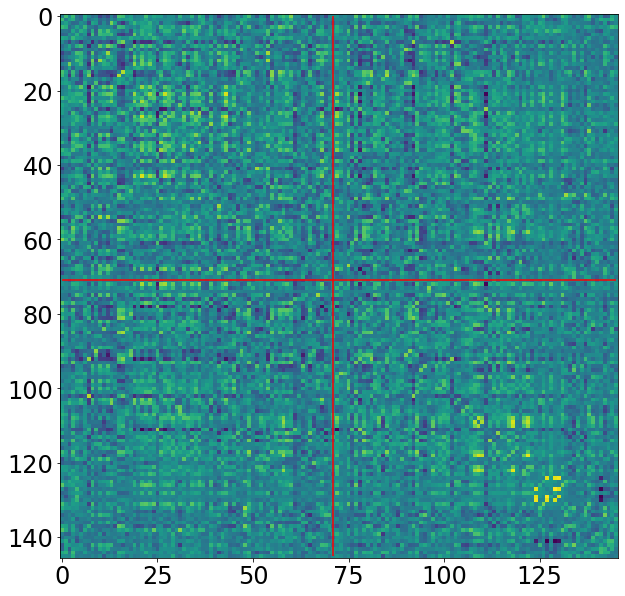

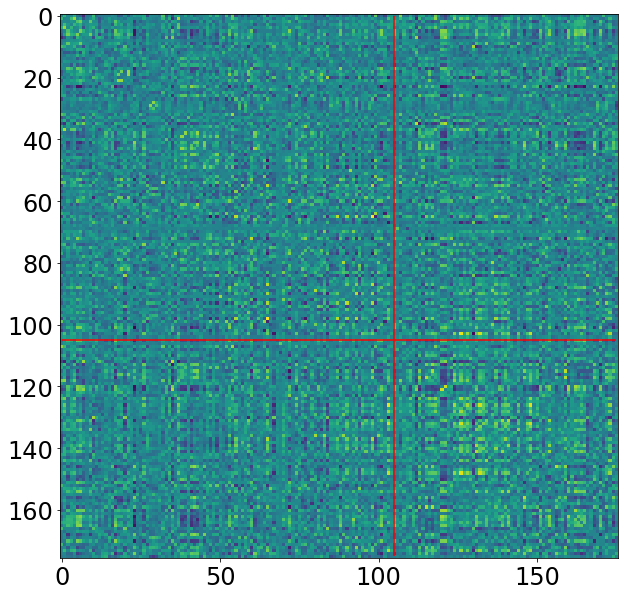

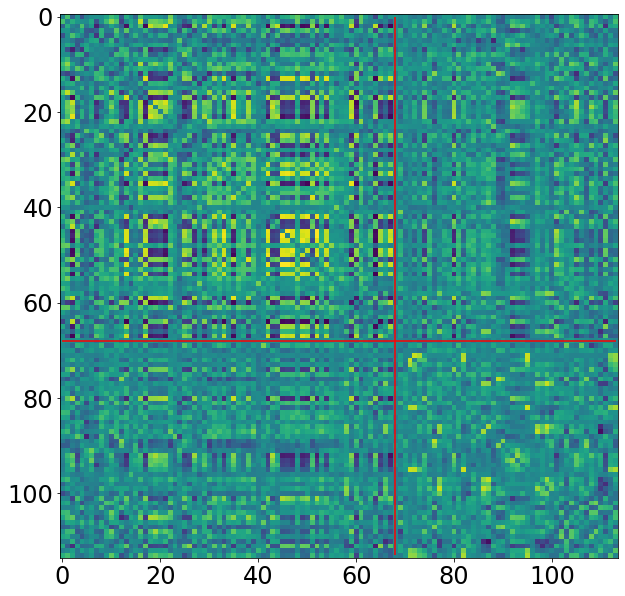

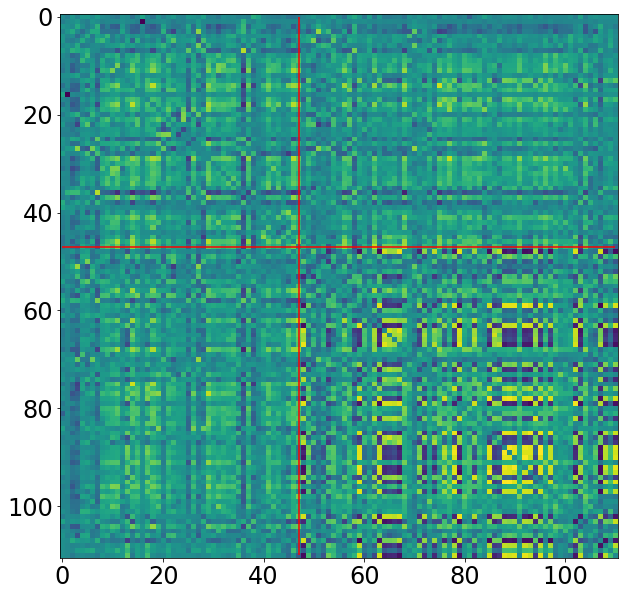

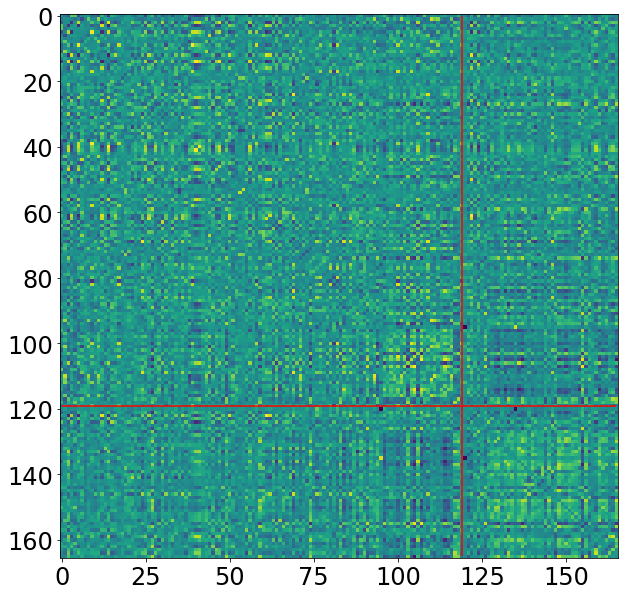

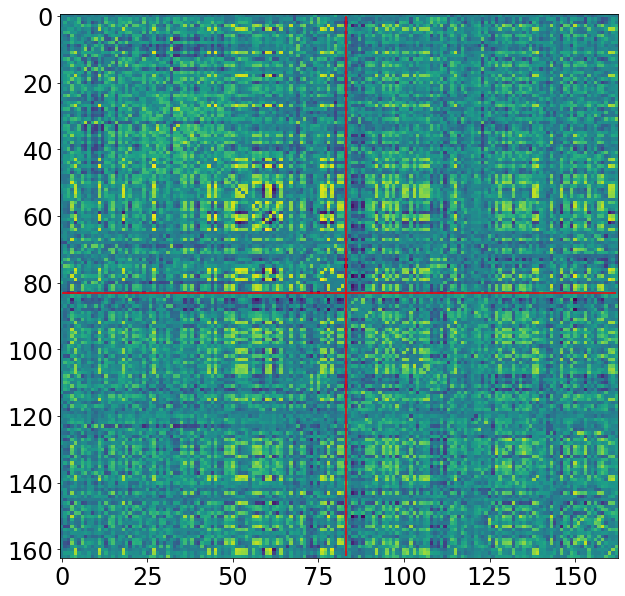

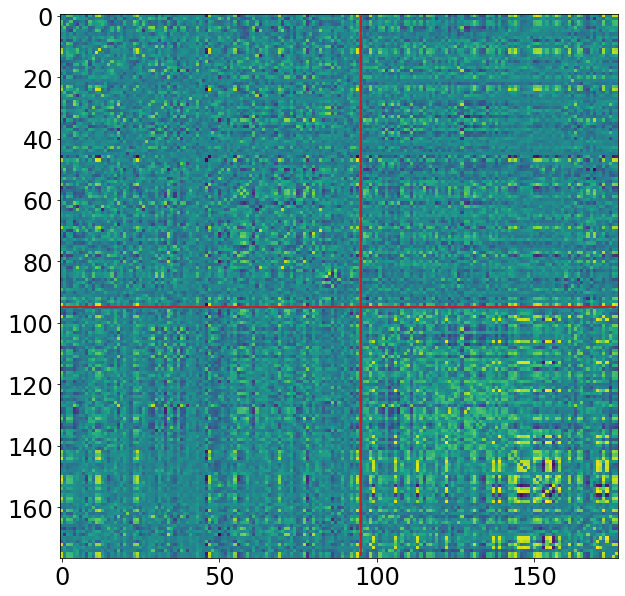

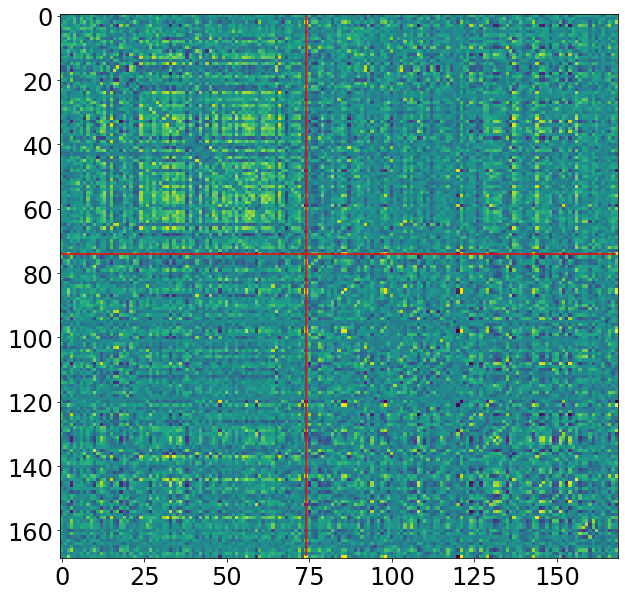

In [115]:
# compare movements from day to day and find significantly changing movements
##
import seaborn
import matplotlib
import random
import scipy
from sklearn.linear_model import LinearRegression,Ridge,Lasso

from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split

font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 24}

#figsavepath = '/home/jupyter/bucket/plots/dlc_matlab_cns_ridge_all_sessions/'
matplotlib.rc('font', **font)

#metadata_file_to_continue = ''

max_p_movement_change = .01
bootstrap_ratio = .5 #fraction of trials in training set
n_bootstrap = 1000 # number of bootstrap repeats

maximum_trial_length_needed = 200 #  frames
percentile_of_trials_can_be_thrown_out = 30 # beacuse of too short

subtract_baseline = True
baseline_frame_num = 3

plot_changing_movements = False
change_of_what = 'mean' #'std','mean'

cells_to_look_at = 'all'#'cn'#'cn'#'cn'#'increasing','decreasing'

mouse_session_to_test = []
p_change_all = []
p_decrease_all = []
p_increase_all = []
cell_id_list_all = []
part_id_list_all = []
movement_amplitude_change_list_all = []
corr_with_cn_on_conditioning_day_all = []
corr_with_cn_before_conditioning_day_all = []
corr_p_with_cn_before_conditioning_day_all = []
delta_tuning_all = []
previous_tuning_all = []
for mouse_now in np.unique(multi_session_dict['mouse']):
    needed_sessions = np.where(np.asarray(multi_session_dict['mouse']) == mouse_now)[0]
    for test_session in needed_sessions[::-1]:
        if len(mouse_session_to_test)>0: # if we want to run in on a particular session
            if not (mouse_session_to_test[0]== mouse_now and mouse_session_to_test[1]== multi_session_dict['session'][test_session]):
                continue

        fit_session = test_session -1 
        if fit_session not in needed_sessions:
            #no previous session
            continue
        
        cn = multi_session_dict['cn'][test_session]
        fit_session_name_list = [multi_session_dict['session'][fit_session]]
        DLC_aligned_fit_session = multi_session_dict['DLC_aligned'][fit_session].copy()
        F_fit_session = multi_session_dict['F'][fit_session].copy()
        trial_end_frames_fit_session = np.asarray(multi_session_dict['trial_end_frames'][fit_session])
        trial_start_frames_fit_session = np.concatenate([[0],trial_end_frames_fit_session[:-1]])
        frame_indices_fit_session_all = []
        for start_frame, end_frame in zip(trial_start_frames_fit_session,trial_end_frames_fit_session):
            frame_indices_fit_session_all.append(np.arange(start_frame,end_frame))
        frame_indices_fit_session_all = np.asarray(frame_indices_fit_session_all,dtype=object)

        DLC_aligned_test_session = multi_session_dict['DLC_aligned'][test_session].copy()
        F_test_session = multi_session_dict['F'][test_session].copy()
        # create an array of frames in each trial for later subselection of frames
        trial_end_frames_test_session = np.asarray(multi_session_dict['trial_end_frames'][test_session])
        trial_start_frames_test_session = np.concatenate([[0],trial_end_frames_test_session[:-1]])
        frame_indices_test_session_all = []
        for start_frame, end_frame in zip(trial_start_frames_test_session,trial_end_frames_test_session):
            frame_indices_test_session_all.append(np.arange(start_frame,end_frame))
        frame_indices_test_session_all = np.asarray(frame_indices_test_session_all,dtype=object)

        for k in DLC_aligned_fit_session.keys():
            if 'mean' in k:# subtract mean from the raw position from day to day
                DLC_aligned_fit_session[k] = DLC_aligned_fit_session[k] - np.nanmean(DLC_aligned_fit_session[k])
                DLC_aligned_test_session[k] = DLC_aligned_test_session[k] - np.nanmean(DLC_aligned_test_session[k])


        DLC_aligned_all = pd.concat([DLC_aligned_fit_session, DLC_aligned_test_session], ignore_index=True)
        print(DLC_aligned_all.shape)



        for k in DLC_aligned_all.keys(): # remove eye and likelihood, also everything mean-related
            if 'likelihood'in k or 'eye' in k[0].lower() or 'pole' in k[0].lower():# or 'mean' in k: 
                DLC_aligned_all.pop(k)
                DLC_aligned_fit_session.pop(k)
                DLC_aligned_test_session.pop(k)
        for k in DLC_aligned_all.keys(): # remove lickport
            if 'lickport' in k[0].lower() or 'pole' in k[0].lower():# or 'mean' in k:# or 'diff_signed' in k:# or 'NoseTip' in k: #remove mean as well
                DLC_aligned_all.pop(k)
                DLC_aligned_fit_session.pop(k)
                DLC_aligned_test_session.pop(k)

        for k in DLC_aligned_all.keys(): # normalize movement data (two sessions together)
            DLC_aligned_fit_session[k] = (DLC_aligned_fit_session[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
            DLC_aligned_test_session[k] = (DLC_aligned_test_session[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()
            DLC_aligned_all[k] = (DLC_aligned_all[k] - DLC_aligned_all[k].mean())/DLC_aligned_all[k].std()

        
        
        trial_lens_test_session = (trial_end_frames_test_session - trial_start_frames_test_session)
        trial_lens_fit_session = trial_end_frames_fit_session -trial_start_frames_fit_session
        minimum_trial_length = np.min([np.percentile(trial_lens_test_session,percentile_of_trials_can_be_thrown_out),
                                       np.percentile(trial_lens_fit_session,percentile_of_trials_can_be_thrown_out)])

        trial_length = int(np.min([maximum_trial_length_needed,minimum_trial_length]))
        needed_trials_test_session = trial_lens_test_session>=minimum_trial_length
        needed_trials_fit_session = trial_lens_fit_session>=minimum_trial_length
        print('trial length is {} frames, {} and {} trials are used from {} and {}'.format(trial_length,
                                                                                           sum(needed_trials_fit_session),
                                                                                            sum(needed_trials_test_session),
                                                                                           multi_session_dict['session'][fit_session],
                                                                                           multi_session_dict['session'][test_session]))
        p_increase_list = []
        p_decrease_list = []
        cell_id_list = []
        part_id_list = []
        
        movement_amplitude_change_list = []
        pearson_with_cn_on_conditioning_day_list = []
        pearson_with_cn_before_conditioning_day_list = []
        pearson_with_cn_before_conditioning_day_p_list = []
        all_fit_session_matrices = []
        all_test_session_matrices = []
        
        delta_tuning_list = []
        previous_tuning_list = []
        for part in DLC_aligned_all.keys():
            fit_session_y_matrix = []
            test_session_y_matrix = []
            for t in np.where(needed_trials_test_session)[0]:
                start_t =trial_start_frames_test_session[t]
                end_t = start_t+trial_length
                test_session_y_matrix.append(DLC_aligned_test_session[part].values[start_t:end_t])
            test_session_y_matrix = np.asarray(test_session_y_matrix)
            if subtract_baseline:
                test_session_y_matrix -= np.nanmean(test_session_y_matrix[:,:baseline_frame_num ],1)[:,np.newaxis]
            if change_of_what == 'mean':
                test_amplitudes =    np.nanmean(test_session_y_matrix,1) 
            elif change_of_what == 'std':
                test_amplitudes =    np.nanstd(test_session_y_matrix,1)
            for t in np.where(needed_trials_fit_session)[0]:
                start_t =trial_start_frames_fit_session[t]
                end_t = start_t+trial_length
                fit_session_y_matrix.append(DLC_aligned_fit_session[part].values[start_t:end_t])
            fit_session_y_matrix = np.asarray(fit_session_y_matrix)   
            if subtract_baseline:
                fit_session_y_matrix -= np.nanmean(fit_session_y_matrix[:,:baseline_frame_num],1)[:,np.newaxis]
            if change_of_what == 'mean':
                fit_amplitudes =    np.nanmean(fit_session_y_matrix,1) 
            elif change_of_what == 'std':
                fit_amplitudes =    np.nanstd(fit_session_y_matrix,1)
            
            all_fit_session_matrices.append(fit_session_y_matrix)
            all_test_session_matrices.append(test_session_y_matrix)
            
            fit_mean_amplitude_bootstrap_list = []
            test_mean_amplitude_bootstrap_list = []
            for bootstrap_i in range(n_bootstrap):
                fit_indices = resample(np.arange(len(fit_amplitudes)))
                fit_mean_amplitude_bootstrap_list.append(np.mean(fit_amplitudes[fit_indices]))
                test_indices = resample(np.arange(len(test_amplitudes)))
                test_mean_amplitude_bootstrap_list.append(np.mean(test_amplitudes[test_indices]))
            fit_mean_amplitude_bootstrap_list = np.asarray(fit_mean_amplitude_bootstrap_list)
            test_mean_amplitude_bootstrap_list = np.asarray(test_mean_amplitude_bootstrap_list)
            amplitudes = test_mean_amplitude_bootstrap_list-fit_mean_amplitude_bootstrap_list
            p_increase = 1-np.sum(amplitudes>0)/len(amplitudes)
            p_decrease = 1-np.sum(amplitudes<0)/len(amplitudes)
            movement_amplitude_change = np.nanmean(amplitudes)
            
            if cells_to_look_at == 'increasing':
                cells_to_test = np.where(multi_session_dict['p_increase'][test_session]<.05)[0]
            elif cells_to_look_at == 'cn':
                cells_to_test = [cn]
            elif cells_to_look_at == 'decreasing':
                cells_to_test = np.where(multi_session_dict['p_decrease'][test_session]<.05)[0]
            elif cells_to_look_at == 'nonchanging':
                cells_to_test = np.where((multi_session_dict['p_decrease'][test_session]>.1) & (multi_session_dict['p_increase'][test_session]>.1))[0]
            elif cells_to_look_at == 'all':
                cells_to_test = np.arange(len(multi_session_dict['p_decrease'][test_session]))
            else:
                print('what cells to look at???')
                adas
                
                
            for cn_now in cells_to_test:
                delta_tuning_list.append(multi_session_dict['delta_amplitude'][test_session][cn_now])
                previous_tuning_list.append(multi_session_dict['previous_amplitude'][test_session][cn_now])
                cell_id_list.append(cn_now)
                part_id_list.append(part)
                p_increase_list.append(p_increase)
                p_decrease_list.append(p_decrease)
                movement_amplitude_change_list.append(movement_amplitude_change)
                pearsons_test, pearsons_test_p = scipy.stats.pearsonr(DLC_aligned_test_session[part].values  , F_test_session[cn_now,:])
                pearson_with_cn_on_conditioning_day_list.append(pearsons_test)
                pearsons_fit, pearsons_fit_p = scipy.stats.pearsonr(DLC_aligned_fit_session[part].values  , F_fit_session[cn_now,:])
                pearson_with_cn_before_conditioning_day_list.append(pearsons_fit)
                pearson_with_cn_before_conditioning_day_p_list.append(pearsons_fit_p)
            if np.min([p_increase,p_decrease])<=max_p_movement_change and plot_changing_movements:
                fig = plt.figure(figsize = [10,10])
                ax1 = fig.add_subplot(1,1,1)
                ax1.plot(np.arange(trial_length)/20,np.nanmean(fit_session_y_matrix,0),'k-')
                ax1.plot(np.arange(trial_length)/20,np.nanmean(test_session_y_matrix,0),'m-')
                ax1.set_title('{} - {} to {} - {} - p = {}'.format(multi_session_dict['mouse'][fit_session],
                                                                   multi_session_dict['session'][fit_session],
                                                                   multi_session_dict['session'][test_session],
                                                                   part,
                                                                  np.round(np.min([p_increase,p_decrease]),5)))
                ax1.set_xlabel('time from trial start (s)')
                ax1.set_ylabel('Z-scored average movement')
        
        bigmatrix = np.concatenate([np.concatenate(all_fit_session_matrices,1),np.concatenate(all_test_session_matrices,1)],0)
        p = np.corrcoef(bigmatrix)
        p[p>.99] = 0
        fig = plt.figure(figsize = [10,10])
        ax = fig.add_subplot(1,1,1)
        ax.imshow(p,aspect = 'auto',interpolation = 'none')
        ax.hlines(all_fit_session_matrices[0].shape[0],0,p.shape[0]-1,color = 'red')
        ax.vlines(all_fit_session_matrices[0].shape[0],0,p.shape[0]-1,color = 'red')
        p_increase_list = np.asarray(p_increase_list)
        p_decrease_list = np.asarray(p_decrease_list)
        
        cell_id_list = np.asarray(cell_id_list)
        part_id_list = np.asarray(part_id_list)
        
        movement_amplitude_change_list = np.asarray(movement_amplitude_change_list)
        pearson_with_cn_on_conditioning_day_list=np.asarray(pearson_with_cn_on_conditioning_day_list)
        pearson_with_cn_before_conditioning_day_list=np.asarray(pearson_with_cn_before_conditioning_day_list)
        pearson_with_cn_before_conditioning_day_p_list=np.asarray(pearson_with_cn_before_conditioning_day_p_list)
        p_change_all.append(np.nanmin([p_increase_list,p_decrease_list],0))
        p_increase_all.append(p_increase_list)
        p_decrease_all.append(p_decrease_list)
        movement_amplitude_change_list_all.append(movement_amplitude_change_list)
        corr_with_cn_on_conditioning_day_all.append(pearson_with_cn_on_conditioning_day_list)
        corr_with_cn_before_conditioning_day_all.append(pearson_with_cn_before_conditioning_day_list)
        corr_p_with_cn_before_conditioning_day_all.append(pearson_with_cn_before_conditioning_day_p_list)
        
        cell_id_list_all.append(cell_id_list)
        part_id_list_all.append(part_id_list)
        
        delta_tuning_list = np.asarray(delta_tuning_list)
        previous_tuning_list = np.asarray(previous_tuning_list)
        
        delta_tuning_all.append(delta_tuning_list)
        previous_tuning_all.append(previous_tuning_list)
        #asdasd

In [107]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


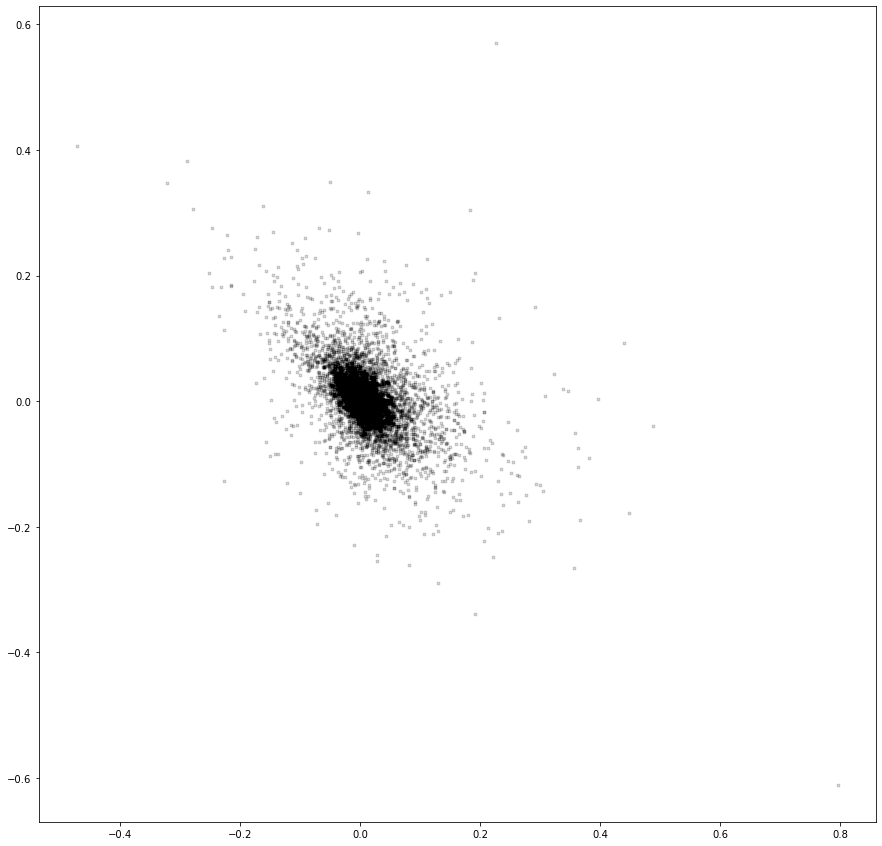

In [100]:
fig = plt.figure(figsize = [15,15])
plt.plot(previous_tuning,delta_tuning,'k.',alpha = .01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


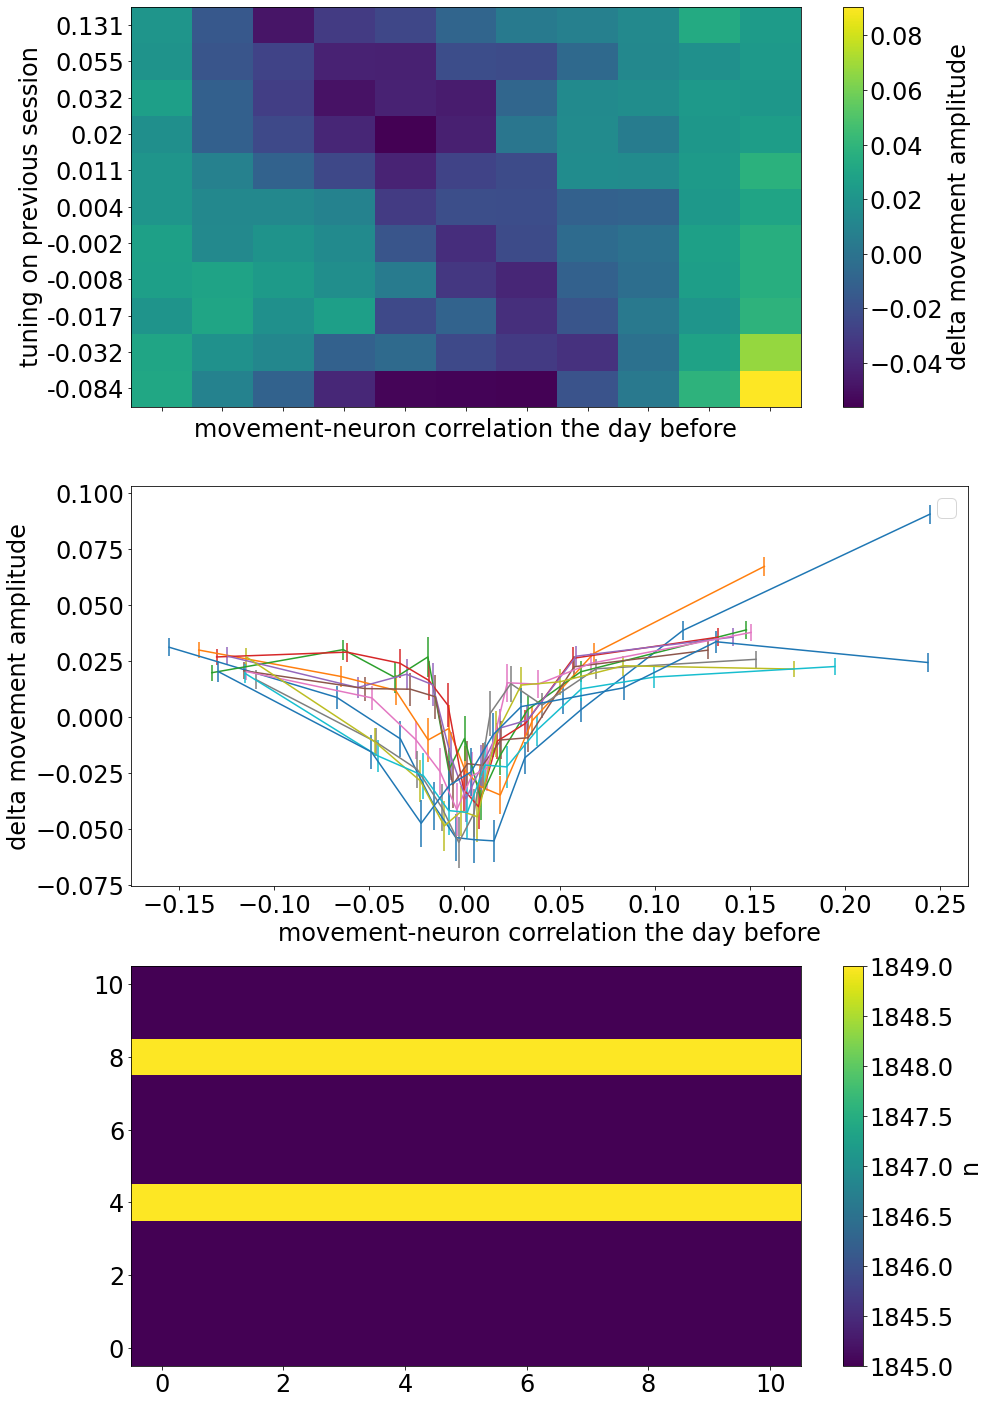

In [116]:
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
delta_tuning = np.concatenate(delta_tuning_all)#
previous_tuning = np.concatenate(previous_tuning_all) # +
current_tuning = previous_tuning+delta_tuning
delta_movement_amplitude = np.concatenate(movement_amplitude_change_list_all)
corr_with_cn_the_day_before = np.concatenate(corr_with_cn_before_conditioning_day_all)


bin_num_y  = 11
bin_num_x = 11


y_base_list_all = delta_tuning
third_axis_label = 'delta tuning'

y_base_list_all = previous_tuning
third_axis_label = 'tuning on previous session'

# y_base_list_all = current_tuning
# third_axis_label = 'tuning on conditioning session'


x_list_all = corr_with_cn_the_day_before
y_list_all =  delta_movement_amplitude

xlabel = 'movement-neuron correlation the day before'

ylabel = 'delta movement amplitude'




x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]


y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
n_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]

        
    x_sorted = np.sort(x_list)
    x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]     
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
        n_matrix[xi,yi] = len(np.unique(x_list[needed_indices]))


fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = ylabel)

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
im = ax.imshow(n_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
fig.colorbar(im,ax = ax,label = 'n')

# fig = plt.figure(figsize = [15,15])
# #ax1 = plt.axes(projection ="3d")
# ax1 = Axes3D(fig)
# ax1.scatter3D(delta_tuning, corr_with_cn_the_day_before, delta_movement_amplitude, marker='.',alpha = .2)
# ax1.set_xlabel('delta tuning')
# ax1.set_ylabel('Correlation with CN the day before')
# ax1.set_zlabel('Delta movement amplitude')
# ax1.view_init(elev=30, azim=66)#, roll=15)

/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Change in mean of movement')

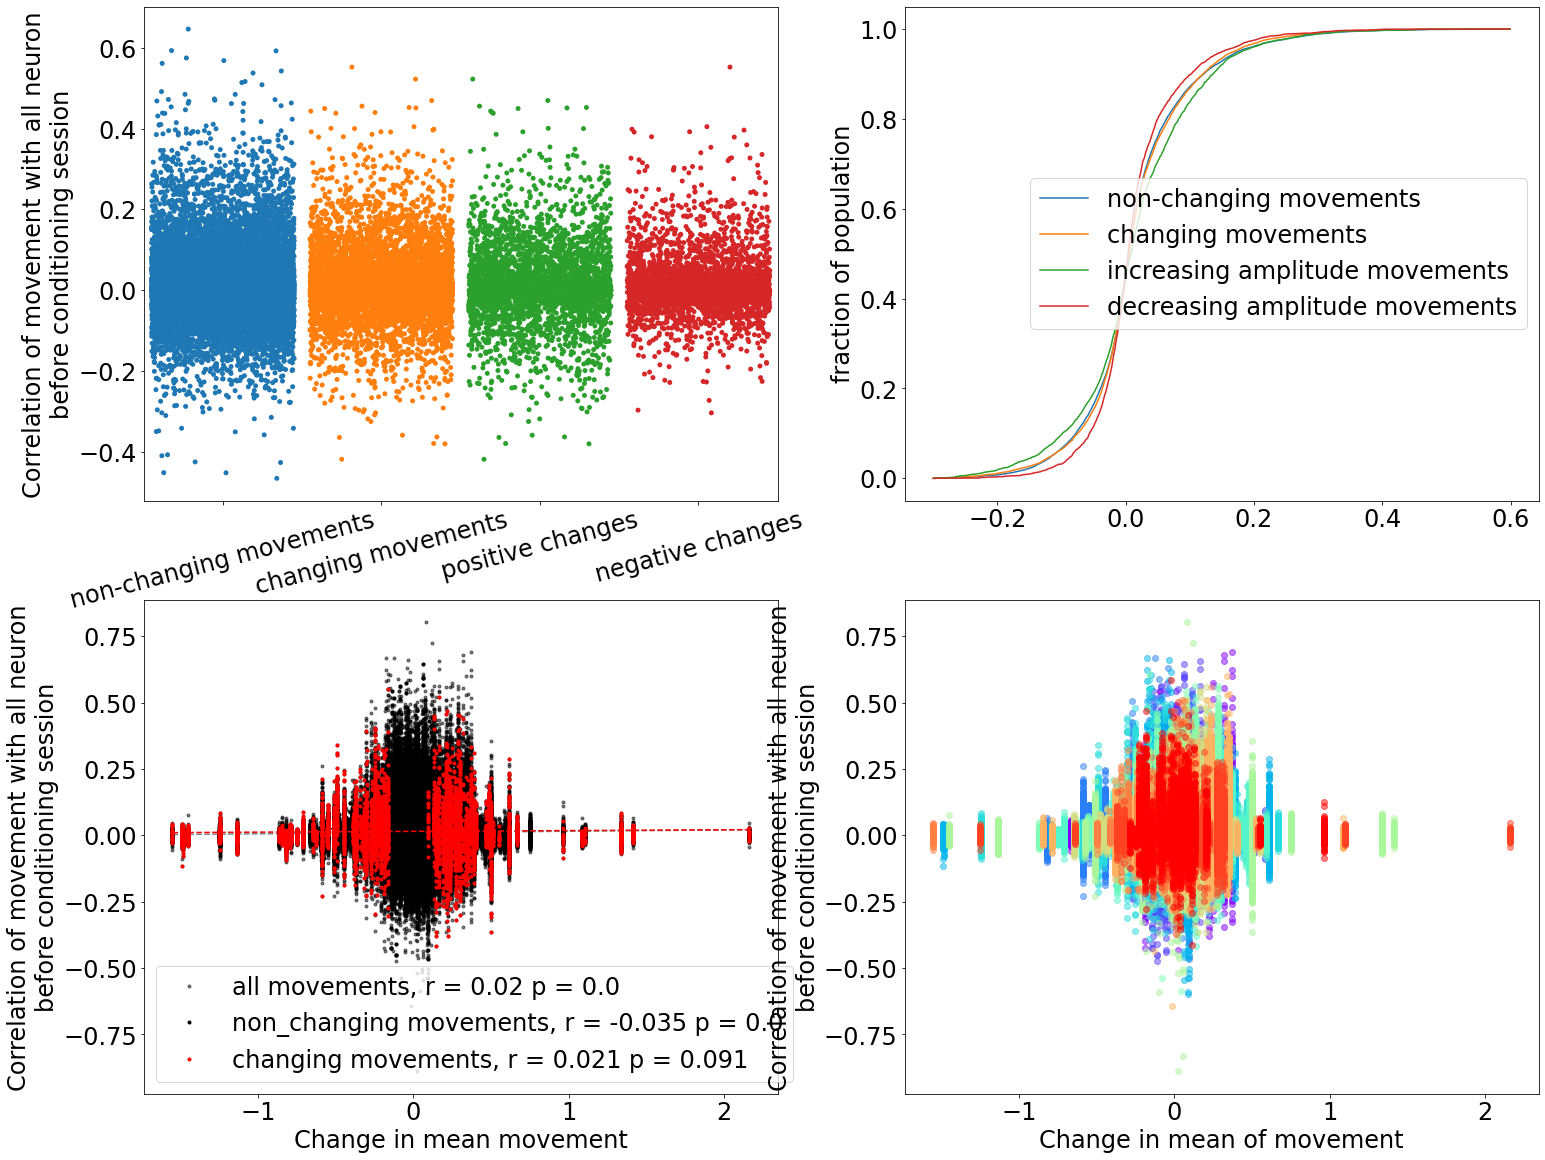

In [117]:
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
max_p_for_movements = .05
max_p_for_correlation_with_movements = 1.01
min_p_for_nonchangin_movements = .1
significantly_correlated_before_conditioning_day = np.concatenate(corr_p_with_cn_before_conditioning_day_all)<=max_p_for_correlation_with_movements
delta_tuning_restriction =( np.concatenate(delta_tuning_all)<-0.05)# & ( np.concatenate(previous_tuning_all)<0) #delta_tuning_all#previous_tuning_all



changing_indices =(np.concatenate(p_change_all)<=max_p_for_movements) & significantly_correlated_before_conditioning_day &delta_tuning_restriction
increasing_indices = (np.concatenate(p_increase_all)<=max_p_for_movements) & significantly_correlated_before_conditioning_day &delta_tuning_restriction
decreasing_indices = (np.concatenate(p_decrease_all)<=max_p_for_movements) & significantly_correlated_before_conditioning_day &delta_tuning_restriction
non_changing_indices = (np.concatenate(p_change_all)>=min_p_for_nonchangin_movements) & significantly_correlated_before_conditioning_day &delta_tuning_restriction
x_values = np.concatenate([['non-changing movements']*sum(non_changing_indices),
                         ['changing movements']*sum(changing_indices),
                         ['positive changes']*sum(increasing_indices),
                         ['negative changes']*sum(decreasing_indices)])
# colors = np.concatenate([['k']*sum(non_changing_indices),
#                          ['g']*sum(changing_indices),
#                          ['r']*sum(increasing_indices),
#                          ['b']*sum(decreasing_indices)])
y_values = np.concatenate([np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices],
                           np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices],
                           np.concatenate(corr_with_cn_before_conditioning_day_all)[increasing_indices],
                           np.concatenate(corr_with_cn_before_conditioning_day_all)[decreasing_indices]])
fig = plt.figure(figsize = [25,20])
ax1 = fig.add_subplot(2,2,1)
sns.stripplot(x_values,y_values,ax=ax1,size = 5,alpha = 1,jitter = .45)#, color = colors)
ax1.set_ylabel('Correlation of movement with {} neuron\nbefore conditioning session'.format(cells_to_look_at))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 15)
ax2 = fig.add_subplot(2,2,2)
xbins = np.arange(-.3,.6,.001)
y_nonchanging,x = np.histogram(np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices],xbins)
y_changing,x = np.histogram(np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices],xbins)
y_increasing,x = np.histogram(np.concatenate(corr_with_cn_before_conditioning_day_all)[increasing_indices],xbins)
y_decreasing,x = np.histogram(np.concatenate(corr_with_cn_before_conditioning_day_all)[decreasing_indices],xbins)

xbins = np.nanmean([xbins[1:],xbins[:-1]],0)

ax2.plot(xbins,np.cumsum(y_nonchanging)/sum(y_nonchanging),label = 'non-changing movements')
ax2.plot(xbins,np.cumsum(y_changing)/sum(y_changing),label = 'changing movements')
ax2.plot(xbins,np.cumsum(y_increasing)/sum(y_increasing),label = 'increasing amplitude movements')
ax2.plot(xbins,np.cumsum(y_decreasing)/sum(y_decreasing),label = 'decreasing amplitude movements')


ax2.set_ylabel('Correlation of movement with {} neuron\nbefore conditioning session'.format(cells_to_look_at))
ax2.set_ylabel('fraction of population')
ax2.legend()


ax3 = fig.add_subplot(2,2,3)

r,t= scipy.stats.pearsonr(np.concatenate(movement_amplitude_change_list_all)[significantly_correlated_before_conditioning_day],np.concatenate(corr_with_cn_before_conditioning_day_all)[significantly_correlated_before_conditioning_day])
ax3.plot(np.concatenate(movement_amplitude_change_list_all)[significantly_correlated_before_conditioning_day],np.concatenate(corr_with_cn_before_conditioning_day_all)[significantly_correlated_before_conditioning_day],'k.',alpha = .5,label = 'all movements, r = {} p = {}'.format(np.round(r,3),np.round(t,3)))
p = np.polyfit(np.concatenate(movement_amplitude_change_list_all)[significantly_correlated_before_conditioning_day],np.concatenate(corr_with_cn_before_conditioning_day_all)[significantly_correlated_before_conditioning_day],1)
xvals = np.percentile(np.concatenate(movement_amplitude_change_list_all),[0,100])
yvals = np.polyval(p,xvals)
ax3.plot(xvals,yvals,'k--',alpha = .5)


r,t= scipy.stats.pearsonr(np.concatenate(movement_amplitude_change_list_all)[non_changing_indices],np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices])
ax3.plot(np.concatenate(movement_amplitude_change_list_all)[non_changing_indices],np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices],'k.',alpha = 1,label = 'non_changing movements, r = {} p = {}'.format(np.round(r,3),np.round(t,3)))
p = np.polyfit(np.concatenate(movement_amplitude_change_list_all)[non_changing_indices],np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices],1)
xvals = np.percentile(np.concatenate(movement_amplitude_change_list_all)[non_changing_indices],[0,100])
yvals = np.polyval(p,xvals)
ax3.plot(xvals,yvals,'k--')


r,t= scipy.stats.pearsonr(np.concatenate(movement_amplitude_change_list_all)[changing_indices],np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices])
ax3.plot(np.concatenate(movement_amplitude_change_list_all)[changing_indices],np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices],'r.',alpha = 1,label = 'changing movements, r = {} p = {}'.format(np.round(r,3),np.round(t,3)))

p = np.polyfit(np.concatenate(movement_amplitude_change_list_all)[changing_indices],np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices],1)
xvals = np.percentile(np.concatenate(movement_amplitude_change_list_all)[changing_indices],[0,100])
yvals = np.polyval(p,xvals)
ax3.plot(xvals,yvals,'r--')



ax3.set_ylabel('Correlation of movement with {} neuron\nbefore conditioning session'.format(cells_to_look_at))
ax3.set_xlabel('Change in {} movement'.format(change_of_what))
ax3.legend()
cmap = cm.get_cmap('rainbow', len(movement_amplitude_change_list_all))    # 11 discrete colors

ax4 = fig.add_subplot(2,2,4)
for i,(x,y) in enumerate(zip(movement_amplitude_change_list_all,corr_with_cn_before_conditioning_day_all)):
    ax4.plot(x,y,'o',label = 'session {}'.format(i),color = cmap(i),alpha = .5)
ax4.set_ylabel('Correlation of movement with {} neuron\nbefore conditioning session'.format(cells_to_look_at))
ax4.set_xlabel('Change in {} of movement'.format(change_of_what))
#ax4.legend()


In [97]:
p_list = []
for session_i in range(len(movement_amplitude_change_list_all)):
    cell_id_list = np.unique(cell_id_list_all[session_i])
    for cell_id in cell_id_list:
        indices = cell_id_list_all[session_i] == cell_id
        movement_amplitudes = movement_amplitude_change_list_all[session_i][indices]
        corrcoefs = corr_with_cn_before_conditioning_day_all[session_i][indices]
        r,p= scipy.stats.pearsonr(movement_amplitudes,corrcoefs)
        p_list.append(p)
        if p<.05:
            fig = plt.figure(figsize = [10,10])
            plt.plot(movement_amplitudes,corrcoefs,'ko')
            plt.title('p = {}'.format(np.round(p,3)))
            plt.ylabel('Correlation of movement with {} neuron ({})\nbefore conditioning session'.format(cells_to_look_at,cell_id))
            plt.xlabel('Change in {} movement'.format(change_of_what))
            pp = np.polyfit(movement_amplitudes,corrcoefs,1)
            xs = np.percentile(movement_amplitudes,[0,100])
            ys = np.polyval(pp,xs)
            plt.plot(xs,ys,'k-')

(array([  156.,   622.,   622.,     0.,   716.,     0.,     0.,     0.,
          364.,   156.,     0.,   716.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,  1080.,  1960.,   364.,   364.,   622.,
          872.,   728.,  2324.,   716.,  1142.,  1080.,  1858.,  3146.,
         3822.,  2636.,  3622.,  4964.,  6050., 11208.,  9040., 11736.,
         9880., 19760., 20484., 14272., 15836., 14426.,  5780.,  8624.,
         7066.,  9686.,  2742.,  5352.,  3310.,  1080.,  1714.,  3404.,
         1650.,   622.,   986.,   364.,     0.,     0.,     0.,   716.,
            0.,     0.,     0.,   156.,     0.,     0.,     0.,   716.,
          156.,     0.,     0.,     0.,     0.,     0.,   716.,   716.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   156.]),
 array([-1.55963436e+00, -1.52254737e+00, -1.48546038e+00, -1.44837340e+00,
        -1.4112864

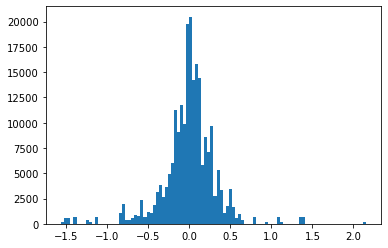

In [72]:
plt.hist(np.concatenate(movement_amplitude_change_list_all),100)

Text(0, 0.5, 'proportion of cells')

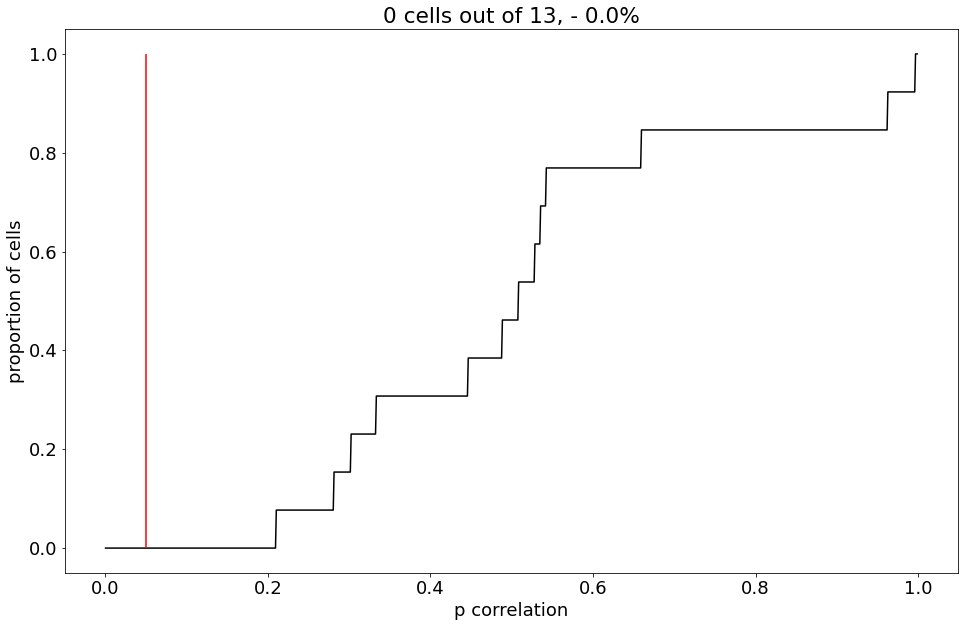

In [98]:
y,x = np.histogram(p_list,np.arange(0,1,.001))
x=np.nanmean([x[1:],x[:-1]],0)
fig = plt.figure(figsize = [16,10])
plt.plot(x,np.cumsum(y)/sum(y),'k-')
plt.vlines(.05,0,1,color = 'red')
plt.title('{} cells out of {}, - {}%'.format(sum(np.asarray(p_list)<.05),len(p_list),np.round(100*sum(np.asarray(p_list)<.05)/len(p_list),1)))
plt.xlabel('p correlation')
plt.ylabel('proportion of cells')

In [99]:
# hierarchical bootstrapping of data
n_bootstrap = 10000
slope_list = []
pearson_r_list = []
pearson_p_list = []
for bootstrap_i in range(n_bootstrap):
    session_indices = resample(np.arange(len(movement_amplitude_change_list_all)))
    movement_amplitudes = np.concatenate(np.asarray(movement_amplitude_change_list_all)[session_indices])
    corrcoefs = np.concatenate(np.asarray(corr_with_cn_before_conditioning_day_all)[session_indices])#
    indices = resample(np.arange(len(movement_amplitudes)))
    movement_amplitudes = movement_amplitudes[indices]
    corrcoefs = corrcoefs[indices]
    p = np.polyfit(movement_amplitudes,corrcoefs,1)
    slope_list.append(p[0])
    r,p= scipy.stats.pearsonr(movement_amplitudes,corrcoefs)
    pearson_r_list.append(r)
    pearson_p_list.append(p)

In [100]:
for session_i in range(len(movement_amplitude_change_list_all)):
    movement_amplitudes = np.asarray(movement_amplitude_change_list_all)[session_i]
    corrcoefs = np.asarray(corr_with_cn_before_conditioning_day_all)[session_i]
    r,p= scipy.stats.pearsonr(movement_amplitudes,corrcoefs)
    if p<.05:
        plt.figure()
        plt.plot(movement_amplitudes,corrcoefs,'k.')
        plt.title('sessoion {}, r = {}'.format(session_i,np.round(r,3)))

Text(0.5, 1.0, 'Pearson R : p = 0.5504')

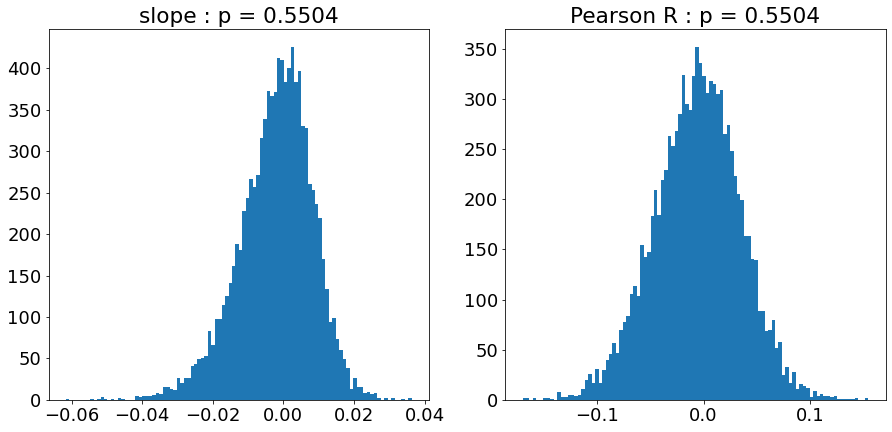

In [102]:
fig = plt.figure(figsize = [15,15])
ax1 = fig.add_subplot(2,2,1)
ax1.hist(slope_list,100)
ax1.set_title('slope : p = {}'.format(np.sum(np.asarray(slope_list)<0)/len(slope_list)))
ax2 = fig.add_subplot(2,2,2)
ax2.hist(pearson_r_list,100)
ax2.set_title('Pearson R : p = {}'.format(np.sum(np.asarray(pearson_r_list)<0)/len(pearson_r_list)))


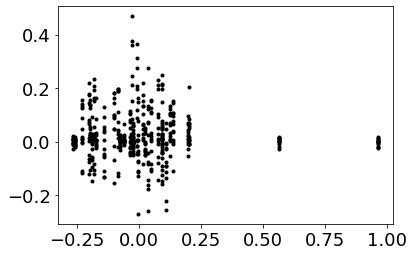

In [92]:
plt.plot(movement_amplitudes,corrcoefs,'k.')

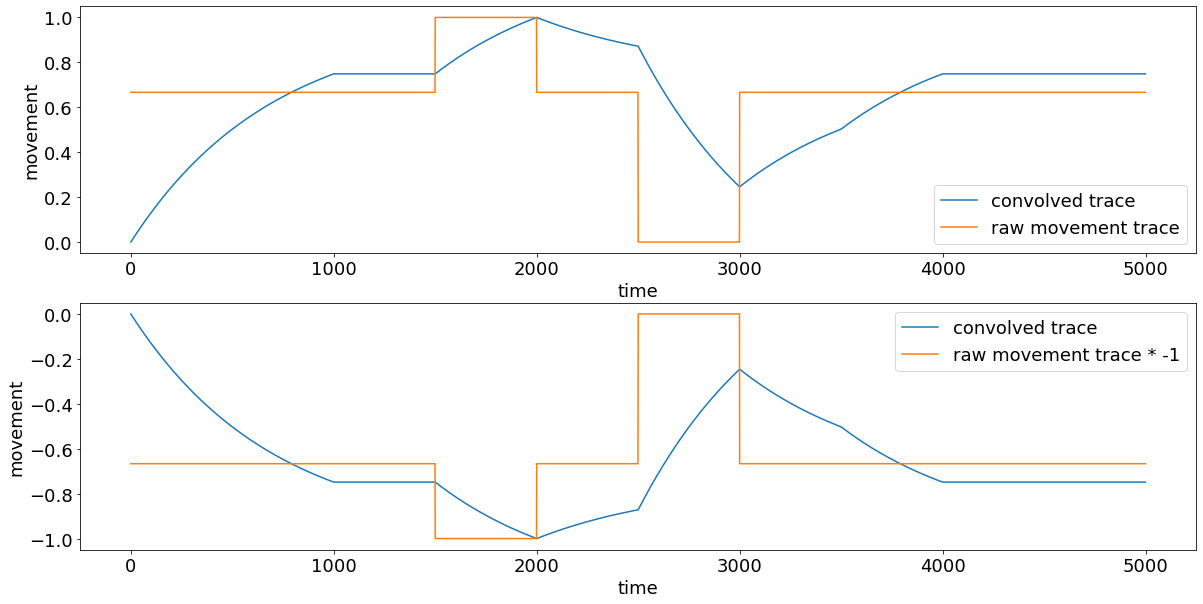

In [93]:
convolve_tau  =.7
amplitude =1
sample_interval = .001
calcium_transient_t = np.arange(0,1,sample_interval)# ms 
decay = np.exp(calcium_transient_t/-convolve_tau)
calcium_transient = decay #rise*decay
calcium_transient = amplitude*calcium_transient/np.max(calcium_transient)
calcium_transient = np.concatenate([np.zeros_like(calcium_transient),calcium_transient])
#plt.plot(calcium_transient)#
test_signal = np.zeros(5000)+20

test_signal[1500:2000]+=10
test_signal[2000:2500]+=-0
test_signal[2500:3000]-=20
test_filt = np.convolve(test_signal,calcium_transient,'same')
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,1,1)
plt.plot(test_filt/np.max(np.abs(test_filt)),label = 'convolved trace')
plt.plot(test_signal/np.max(np.abs(test_signal)),label = 'raw movement trace')
#plt.xlim([0,10000])
plt.ylabel('movement')
plt.xlabel('time')
plt.legend()


test_signal = test_signal*-1#+30
test_filt = np.convolve(test_signal,calcium_transient,'same')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(test_filt/np.max(np.abs(test_filt)),label = 'convolved trace')
ax2.plot(test_signal/np.max(np.abs(test_signal)),label = 'raw movement trace * -1')
#ax2.xlim([0,10000])
ax2.set_ylabel('movement')
ax2.set_xlabel('time')
ax2.legend()

Text(0, 0.5, 'cumulative counts')

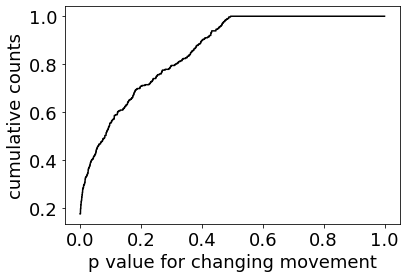

In [256]:
y,x = np.histogram(np.concatenate(p_change_all),np.arange(0,1,.0001))
x = np.nanmean([x[:-1],x[1:]],0)
plt.plot(x,np.cumsum(y)/sum(y),'k-')
plt.xlabel('p value for changing movement')
plt.ylabel('cumulative counts')

Text(0, 0.5, 'biggest correlation of CN with decreasing movements')

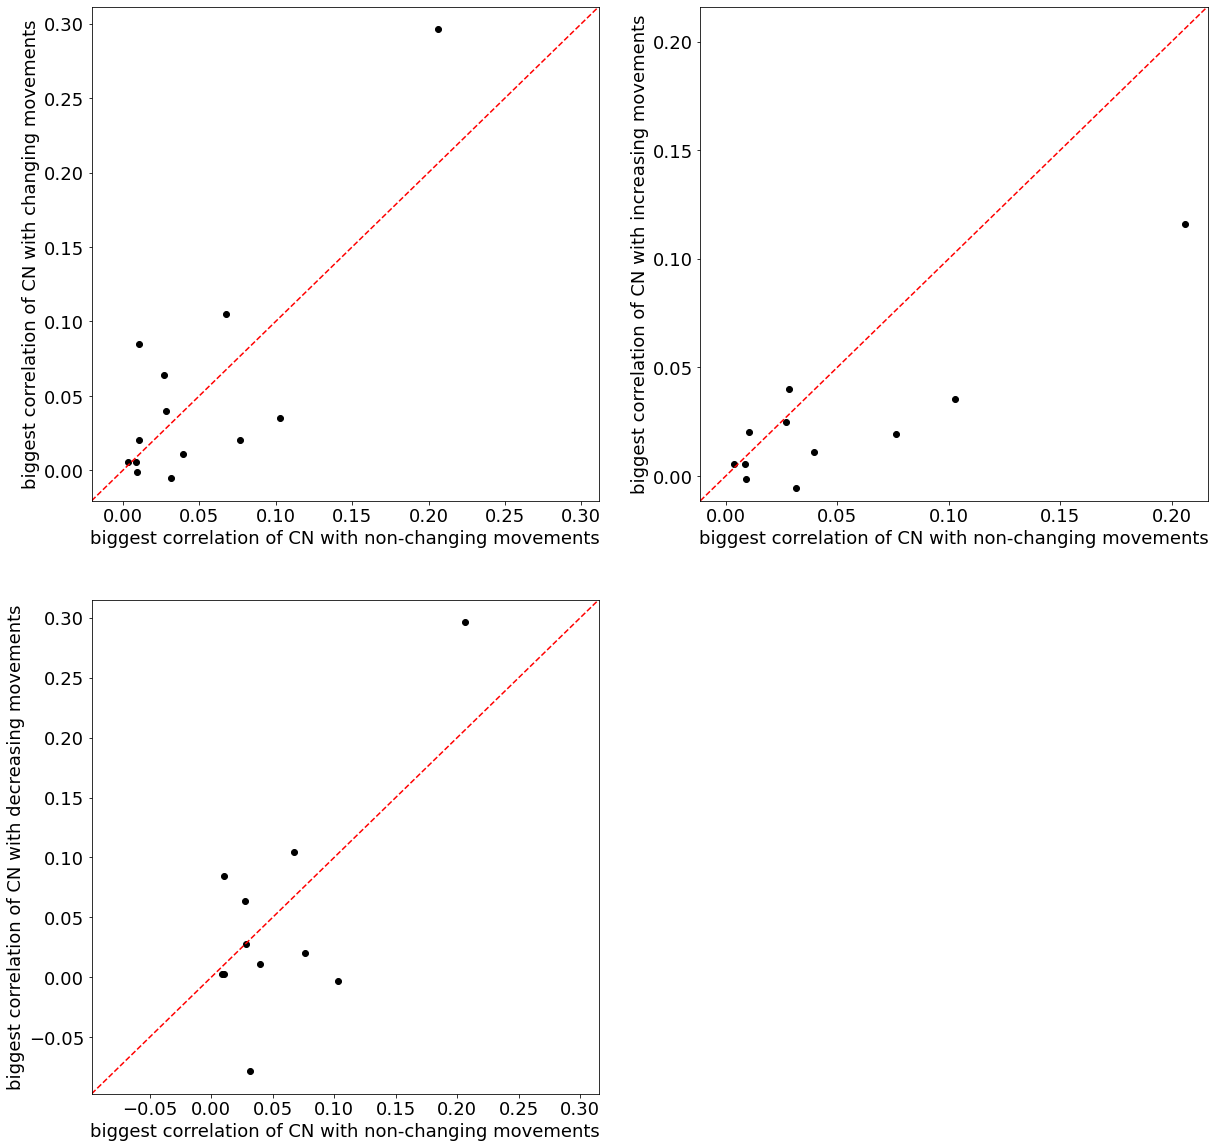

In [281]:
max_p_for_changing_movements = 0.05
min_p_for_non_changing_movements = .1

max_ccs_all = []
max_ccs_changing_movements=  []
max_ccs_nonchanging_movements=  []
max_ccs_decreasing_movements=  []
max_ccs_increasing_movements=  []
for session_i in np.arange(len(corr_with_cn_before_conditioning_day_all)):
    max_idx = np.argmax(np.abs(corr_with_cn_before_conditioning_day_all[session_i]))
    max_val = corr_with_cn_before_conditioning_day_all[session_i][max_idx]
    max_ccs_all.append(max_val)
    
    
    changing_indices = p_change_all[session_i] <=max_p_for_changing_movements
    if sum(changing_indices)==0:
        max_ccs_changing_movements.append(np.nan)
        # continue
        # changing_indices = np.ones(len(p_decrease_all[session_i]))==2
        # changing_indices[np.argmin(p_decrease_all[session_i])] = True
    else:
        max_idx = np.argmax(corr_with_cn_before_conditioning_day_all[session_i][changing_indices])
        max_ccs_changing_movements.append(corr_with_cn_before_conditioning_day_all[session_i][changing_indices][max_idx])
        
        
    changing_indices = p_decrease_all[session_i] <=max_p_for_changing_movements
    if sum(changing_indices)==0:
        max_ccs_decreasing_movements.append(np.nan)
        # continue
        # changing_indices = np.ones(len(p_decrease_all[session_i]))==2
        # changing_indices[np.argmin(p_decrease_all[session_i])] = True
    else:
        max_idx = np.argmax(corr_with_cn_before_conditioning_day_all[session_i][changing_indices])
        max_ccs_decreasing_movements.append(corr_with_cn_before_conditioning_day_all[session_i][changing_indices][max_idx])
    changing_indices = p_increase_all[session_i] <=max_p_for_changing_movements
    if sum(changing_indices)==0:
        max_ccs_increasing_movements.append(np.nan)
        # continue
        # changing_indices = np.ones(len(p_decrease_all[session_i]))==2
        # changing_indices[np.argmin(p_decrease_all[session_i])] = True
    else:
        max_idx = np.argmax(corr_with_cn_before_conditioning_day_all[session_i][changing_indices])
        max_ccs_increasing_movements.append(corr_with_cn_before_conditioning_day_all[session_i][changing_indices][max_idx])
    
    nonchanging_indices = p_change_all[session_i] >min_p_for_non_changing_movements
    max_idx = np.argmax(corr_with_cn_before_conditioning_day_all[session_i][nonchanging_indices])
    max_ccs_nonchanging_movements.append(corr_with_cn_before_conditioning_day_all[session_i][nonchanging_indices][max_idx])
fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(2,2,1)
ax.plot(max_ccs_nonchanging_movements,max_ccs_changing_movements,'ko')
limits = np.concatenate([ax.get_xlim(),ax.get_ylim()])
limits = [np.nanmin(limits),np.nanmax(limits)]
ax.plot(limits,limits,'r--')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xlabel('biggest correlation of CN with non-changing movements')
ax.set_ylabel('biggest correlation of CN with changing movements')


ax = fig.add_subplot(2,2,2)
ax.plot(max_ccs_nonchanging_movements,max_ccs_increasing_movements,'ko')
limits = np.concatenate([ax.get_xlim(),ax.get_ylim()])
limits = [np.nanmin(limits),np.nanmax(limits)]
ax.plot(limits,limits,'r--')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xlabel('biggest correlation of CN with non-changing movements')
ax.set_ylabel('biggest correlation of CN with increasing movements')

ax = fig.add_subplot(2,2,3)
ax.plot(max_ccs_nonchanging_movements,max_ccs_decreasing_movements,'ko')
limits = np.concatenate([ax.get_xlim(),ax.get_ylim()])
limits = [np.nanmin(limits),np.nanmax(limits)]
ax.plot(limits,limits,'r--')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xlabel('biggest correlation of CN with non-changing movements')
ax.set_ylabel('biggest correlation of CN with decreasing movements')
# ax.hist(max_ccs_all,alpha = .5)
# ax.hist(max_ccs_changing_movements,alpha = .5)

In [155]:
max_val

-0.17966191385642127

/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Correlation with CN before conditioning session')

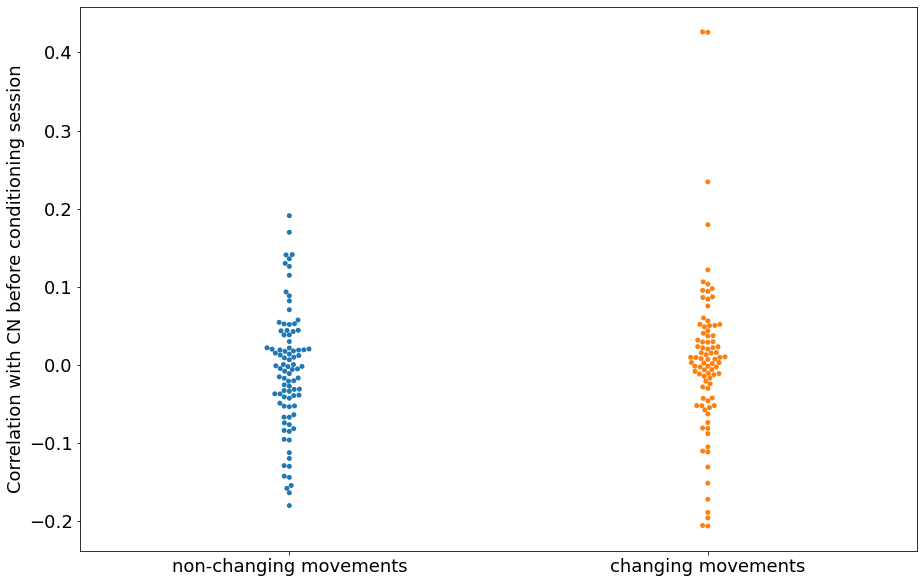

In [156]:
import seaborn as sns
changing_indices = np.concatenate(p_change_all)<=0.01
non_changing_indices = np.concatenate(p_change_all)>=0.2
x_values = np.concatenate([['non-changing movements']*sum(non_changing_indices),
                         ['changing movements']*sum(changing_indices)])
y_values = np.concatenate([np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices],
                           np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices]])
fig = plt.figure(figsize = [15,10])
ax1 = fig.add_subplot(1,1,1)
sns.swarmplot(x_values,y_values,ax=ax1)
ax1.set_ylabel('Correlation with CN before conditioning session')




/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

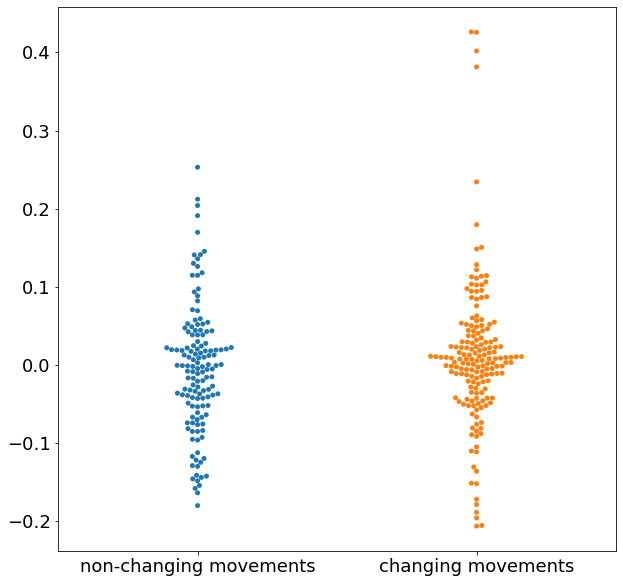

In [157]:
import seaborn as sns
changing_indices = np.concatenate(p_change_all)<=0.1
non_changing_indices = np.concatenate(p_change_all)>=0.1
x_values = np.concatenate([['non-changing movements']*sum(non_changing_indices),
                         ['changing movements']*sum(changing_indices)])
y_values = np.concatenate([np.concatenate(corr_with_cn_before_conditioning_day_all)[non_changing_indices],
                           np.concatenate(corr_with_cn_before_conditioning_day_all)[changing_indices]])
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(1,1,1)
sns.swarmplot(x_values,y_values,ax=ax1)


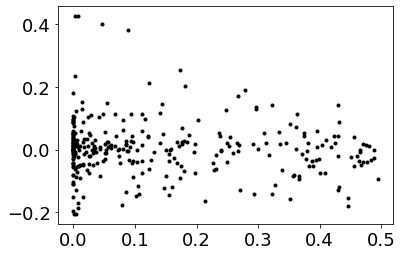

In [158]:
plt.plot(np.concatenate(p_change_all),np.concatenate(corr_with_cn_before_conditioning_day_all),'k.')

In [159]:
np.min(p_increase_list)

0.0020000000000000018

(array([2., 2., 1., 0., 4., 2., 3., 3., 3., 4.]),
 array([0.    , 0.0998, 0.1996, 0.2994, 0.3992, 0.499 , 0.5988, 0.6986,
        0.7984, 0.8982, 0.998 ]),
 <BarContainer object of 10 artists>)

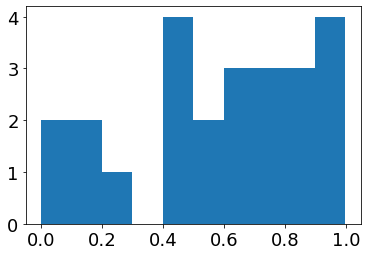

In [160]:
plt.hist(p_decrease_list)